In [2]:
# The script is loading the Andor-3 data from the .h5 files produced from the LCLSII DAQ
# Last ran 07/28/25

In [3]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def rebin_1d_mean(arr, fct):
    fct_rem = len(arr)%fct
    if fct_rem > 0:
        arr = arr[:-fct_rem]
    new_size = (np.floor(len(arr)/fct)).astype(int)
    old_size = len(arr)
    factor = old_size // new_size
    return arr.reshape(new_size, factor).mean(axis=1)

In [4]:
folderFiles = '/sdf/data/rfar/timodo/andordata/'
run3_files = [
    'ued1011086_Run0003_part4.h5',
]
run3_paths = [os.path.join(folderFiles, f) for f in run3_files]

def load_andor_h5(filename):
    result = {'filename': filename}
    try:
        with h5py.File(filename, 'r') as data:
            timestamp = np.array(data['timestamp'])
            order_step = timestamp.argsort()
            ad_ufa = None
            if 'andor/full_area' in data:
                ad_ufa = np.array(data['andor/full_area'])[order_step]
            posi_stage = None
            if 'scan/UED:USR:MMN:06:06' in data:
                posi_stage = np.array(data['scan/UED:USR:MMN:06:06'])[order_step]
            elif 'epics/MOTR_AS01_MC06_CH6' in data:
                posi_stage = np.array(data['epics/MOTR_AS01_MC06_CH6'])[order_step]
            else:
                posi_stage = np.arange(len(timestamp))
            result.update({
                'timestamp': timestamp,
                'ad_ufa': ad_ufa,
                'posi_stage': posi_stage
            })
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        result.update({'timestamp': None, 'ad_ufa': None, 'posi_stage': None})
    return result

all_data = []
for fp in tqdm(run3_paths, desc="Loading .h5 files"):
    data = load_andor_h5(fp)
    all_data.append(data)

Loading .h5 files: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


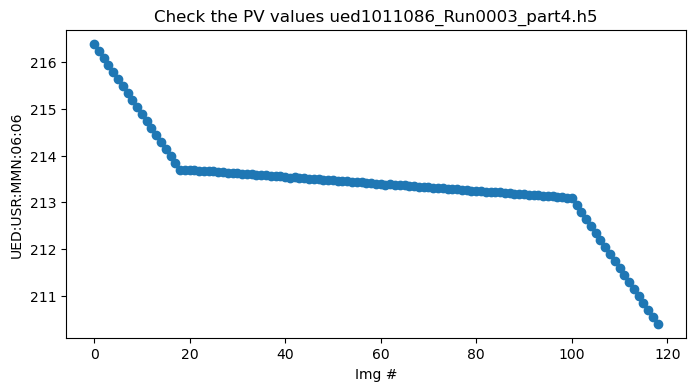

In [5]:
for data in all_data:
    posi_stage = data['posi_stage']
    fname = os.path.basename(data['filename'])
    plt.figure(figsize=(8,4))
    plt.plot(np.arange(len(posi_stage)), posi_stage, 'o')
    plt.xlabel('Img #')
    plt.ylabel('UED:USR:MMN:06:06')
    plt.title(f"Check the PV values {fname}")
    plt.show()

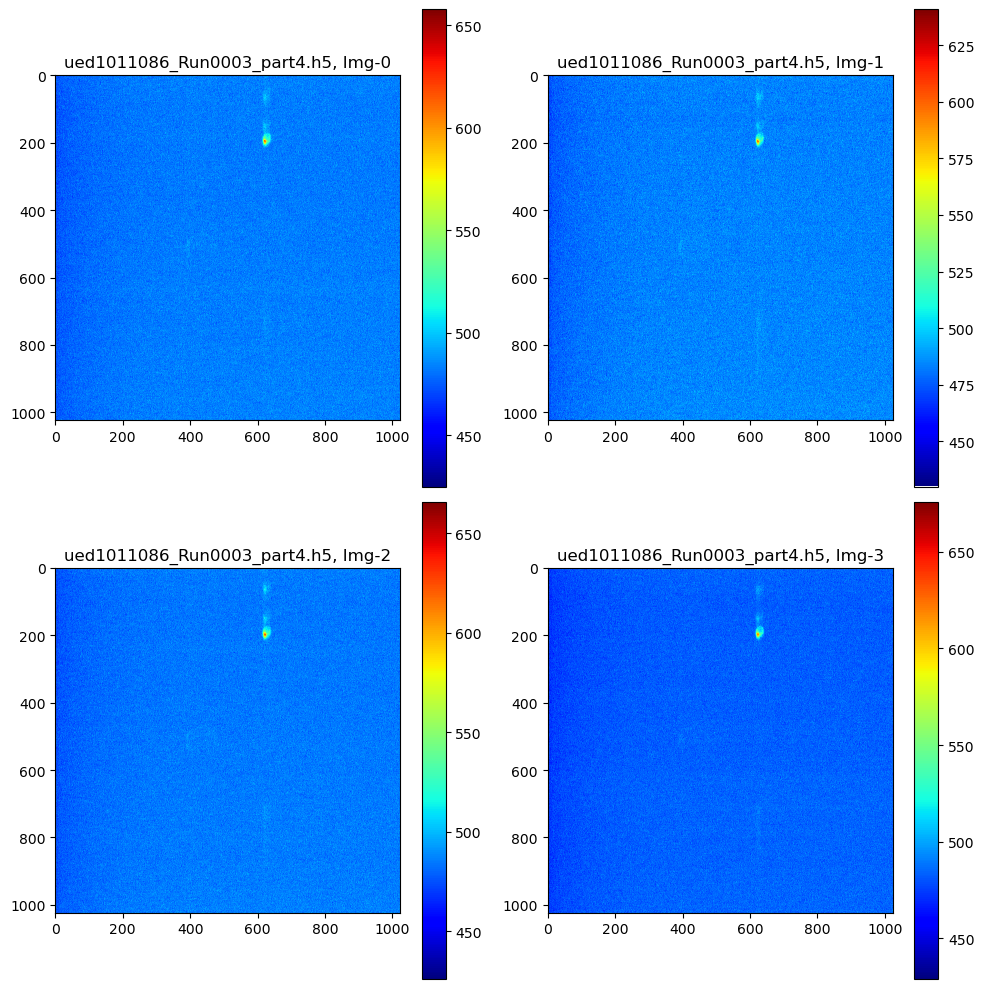

In [6]:
for data in all_data:
    ad_ufa = data['ad_ufa']
    fname = os.path.basename(data['filename'])
    if ad_ufa is not None:
        fig, axes = plt.subplots(2, 2, figsize=(10,10))
        for i in range(4):
            ax = axes[i//2, i%2]
            im = ax.imshow(ad_ufa[i], cmap='jet')
            ax.set_title(f"{fname}, Img-{i}")
            plt.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()

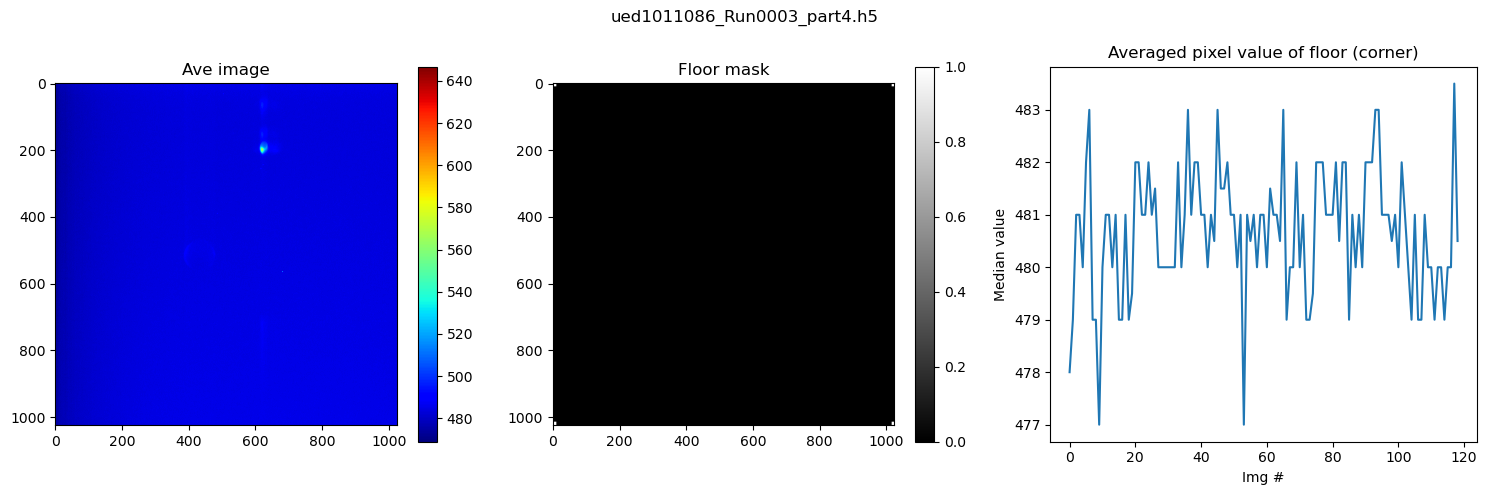

In [7]:
for data in all_data:
    ad_ufa = data['ad_ufa']
    fname = os.path.basename(data['filename'])
    if ad_ufa is not None:
        # Average image
        ave_img = ad_ufa.mean(axis=0)
        # Floor mask (corners, e.g., 10x10 pixels in each corner)
        mask = np.zeros_like(ave_img, dtype=bool)
        mask[:10, :10] = True
        mask[-10:, :10] = True
        mask[:10, -10:] = True
        mask[-10:, -10:] = True
        # Median value of floor pixels for each image
        floor_medians = [np.median(img[mask]) for img in ad_ufa]
        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        im0 = axes[0].imshow(ave_img, cmap='jet')
        axes[0].set_title('Ave image')
        plt.colorbar(im0, ax=axes[0])
        im1 = axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Floor mask')
        plt.colorbar(im1, ax=axes[1])
        axes[2].plot(floor_medians)
        axes[2].set_title('Averaged pixel value of floor (corner)')
        axes[2].set_xlabel('Img #')
        axes[2].set_ylabel('Median value')
        plt.suptitle(fname)
        plt.tight_layout()
        plt.show()

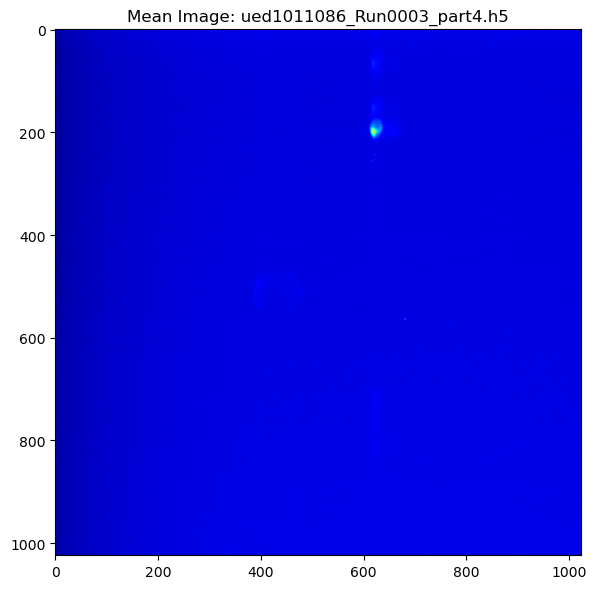

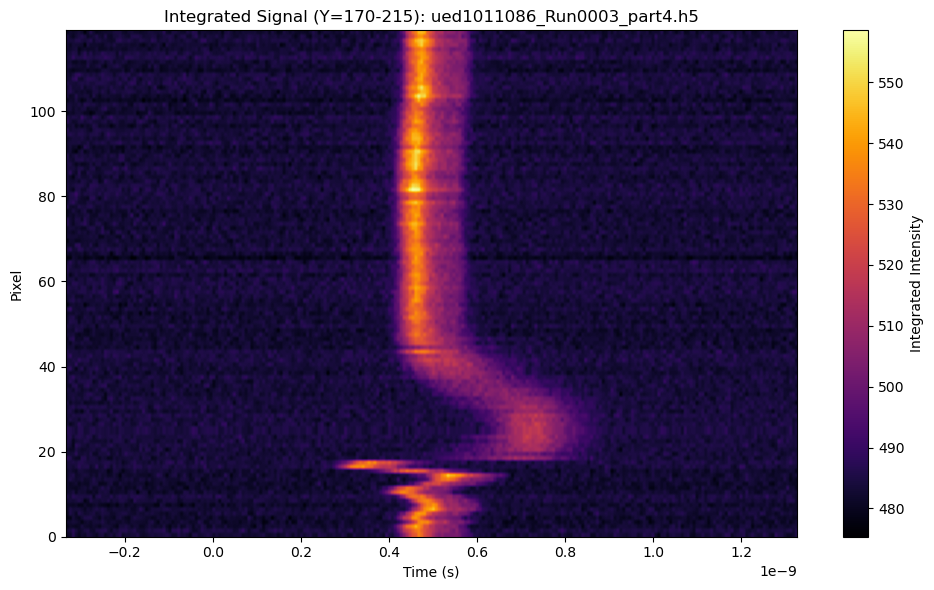

In [8]:
C = 3e8  # Speed of light (m/s)

for data in all_data:
    ad_ufa = data['ad_ufa']
    fname = os.path.basename(data['filename'])
    if ad_ufa is not None:
        plt.figure(figsize=(7,6))
        mean_img = ad_ufa.mean(axis=0)
        plt.imshow(mean_img, cmap='jet')
        plt.title(f"Mean Image: {fname}")
        plt.tight_layout()
        plt.show()

        y1, y2 = 170, 215
        x1, x2 = 500, 750

        inte_step = ad_ufa[:, y1:y2, :].mean(axis=1)
        n_x_pixels = inte_step.shape[1]
        PV = np.arange(n_x_pixels)
        T = (2 * (PV - 550)) / (1000 * C)  # Time in seconds

        idx1, idx2 = x1, x2
        time_window = T[idx1:idx2]
        inte_window = inte_step[:, idx1:idx2]

        plt.figure(figsize=(10, 6))
        plt.imshow(
            inte_window,
            cmap='inferno',
            aspect='auto',
            extent=[time_window[0], time_window[-1], 0, inte_step.shape[0]]
        )
        plt.title(f"Integrated Signal (Y={y1}-{y2}): {fname}")
        plt.xlabel("Time (s)")
        plt.ylabel("Pixel")
        plt.colorbar(label='Integrated Intensity')
        plt.tight_layout()
        plt.show()

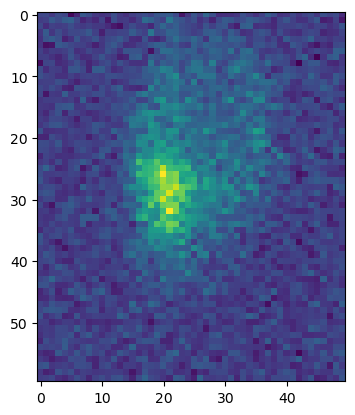

In [16]:
img = ad_ufa[0]
plt.imshow(img[170:230, 600:650])

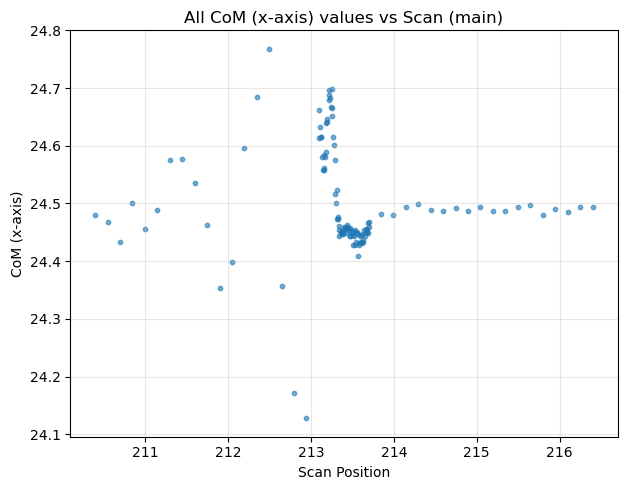

In [17]:
def compute_com_x(image):
    total = image.sum()
    if total == 0:
        return np.nan
    indices = np.arange(image.shape[1])
    com_x = (indices[None, :] * image).sum() / total
    return com_x

if len(all_data) > 0:
    img_com_2_main = np.array([compute_com_x(img[170:230, 600:650]) for img in all_data[0]['ad_ufa']])
    scan_var_1_main = all_data[0]['posi_stage']
else:
    img_com_2_main = None
    scan_var_1_main = None

plt.figure(figsize=(12, 5))
if img_com_2_main is not None and scan_var_1_main is not None:
    plt.subplot(1, 2, 1)
    plt.scatter(scan_var_1_main, img_com_2_main, s=10, color='tab:blue', alpha=0.6)
    plt.xlabel('Scan Position')
    plt.ylabel('CoM (x-axis)')
    plt.title('All CoM (x-axis) values vs Scan (main)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

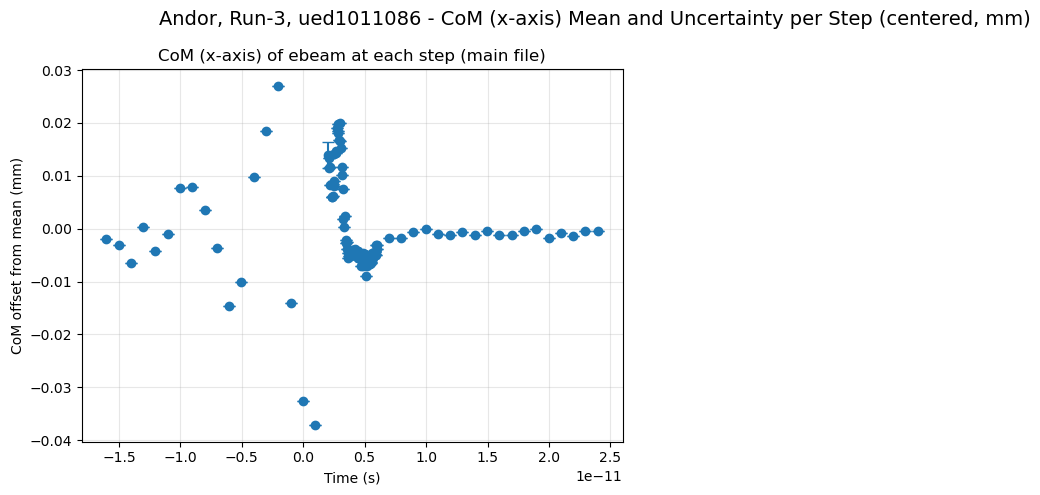

In [18]:
# Define masks for valid data points in x-axis range
main_mask = np.isfinite(img_com_2_main)
min_val, max_val = 0, 1000
valid_main = main_mask & (img_com_2_main > min_val) & (img_com_2_main < max_val)

# Average for centering
avg_main = np.nanmean(img_com_2_main[valid_main]) if np.any(valid_main) else 0
C = 3e8  # Speed of light, m/s

# Stepwise statistics functions
def stepwise_stats(com_array, scan_array, mask, avg):
    steps = np.unique(scan_array[mask])
    means, stds, times = [], [], []
    for s in steps:
        step_mask = (scan_array == s) & mask
        vals = com_array[step_mask]
        if len(vals) > 0:
            means.append((np.nanmean(vals) - avg) * 100e-6 * 1000)
            stds.append(np.nanstd(vals) * 100e-6 * 1000)
            times.append(2 * (s - 212.8) / (1000 * C))
    return np.array(times), np.array(means), np.array(stds)

# Calculate time, mean, std for each scan step
time_main, mean_main, std_main = stepwise_stats(img_com_2_main, scan_var_1_main, valid_main, avg_main)

time_main_rescaled = time_main

# Error bar plot for main and part datasets with rescaled x-axis
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.errorbar(time_main_rescaled, mean_main, yerr=std_main, fmt='o', capsize=4, color='tab:blue', linestyle='none')
plt.xlabel('Time (s)')
plt.ylabel('CoM offset from mean (mm)')
plt.title('CoM (x-axis) of ebeam at each step (main file)')
plt.grid(True, alpha=0.3)

plt.suptitle('Andor, Run-3, ued1011086 - CoM (x-axis) Mean and Uncertainty per Step (centered, mm)', fontsize=14)
plt.tight_layout()
plt.show()